We can use the Biwi Kinect Head Pose Database to train machine learning models for head pose estimation. This is a computer vision task where the goal is to predict the orientation of a person's head in 3D space.

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)


In [2]:
path.ls()

(#50) [Path('/home/manas/.fastai/data/biwi_head_pose/13'),Path('/home/manas/.fastai/data/biwi_head_pose/09.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/19'),Path('/home/manas/.fastai/data/biwi_head_pose/16'),Path('/home/manas/.fastai/data/biwi_head_pose/readme.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/19.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/14'),Path('/home/manas/.fastai/data/biwi_head_pose/22.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/22'),Path('/home/manas/.fastai/data/biwi_head_pose/06.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/02'),Path('/home/manas/.fastai/data/biwi_head_pose/20.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/09'),Path('/home/manas/.fastai/data/biwi_head_pose/21.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/18.obj'),Path('/home/manas/.fastai/data/biwi_head_pose/08'),Path('/home/manas/.fastai/data/biwi_head_pose/24'),Path('/home/manas/.fastai/data/biwi_head_pose/07.obj'),Path('/home/manas/.fastai/data/biwi

In [3]:
(path/'01').ls()

(#1000) [Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00042_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00368_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00122_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00249_rgb.jpg'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00120_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00058_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00270_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00387_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00404_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00472_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00294_rgb.jpg'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00103_pose.txt'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_00085_rgb.jpg'),Path('/home/manas/.fastai/data/biwi_head_pose/01/frame_000

In [4]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/home/manas/.fastai/data/biwi_head_pose/13/frame_00249_pose.txt')

In [5]:
k = 1
im = PILImage.create(img_files[k])
im.shape

(480, 640)

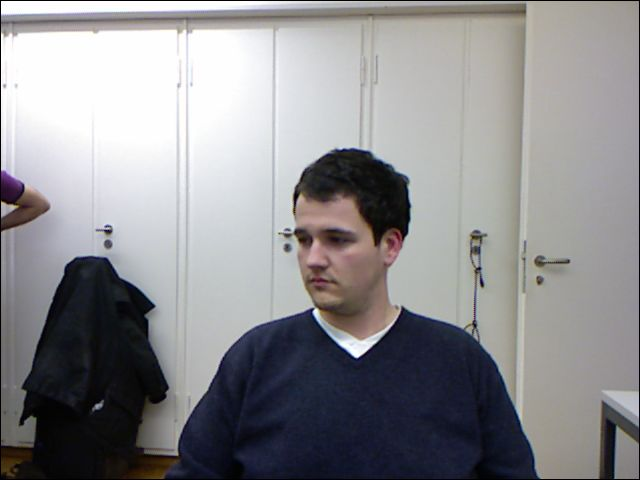

In [6]:
im.to_thumb(1000)

we’ll just show the function we use toWe can pass this function to DataBlock as get_y, since it is responsible for labeling
each item. We’ll resize the images to half their input size, to speed up training a bit.
extract the head center point:



In [7]:
import numpy as np
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f),skip_header=3)
    c1 = ctr[0]*cal[0][0]/ctr[2]+cal[0][2]
    c2 = ctr[1]*cal[1][1]/ctr[2]+cal[1][2]
    return tensor([c1,c2])
#lets just check it out
get_ctr(img_files[0])


tensor([380.6165, 244.0211])

We can pass this function to DataBlock as get_y, since it is responsible for labeling
each item. We’ll resize the images to half their input size, to speed up training a bit.

One important point to note is that we should not just use a random splitter. The
same people appear in multiple images in this dataset, but we want to ensure that our
model can generalize to people that it hasn’t seen yet. Each folder in the dataset con‐
tains the images for one person. Therefore, we can create a splitter function that
returns True for just one person, resulting in a validation set containing just that per‐
son’s images.


The only other difference from the previous data block examples is that the second
block is a PointBlock. This is necessary so that fastai knows that the labels represent
coordinates; that way, it knows that when doing data augmentation, it should do the
same augmentation to these coordinates as it does to the images

In [8]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
    Normalize.from_stats(*imagenet_stats)]
)

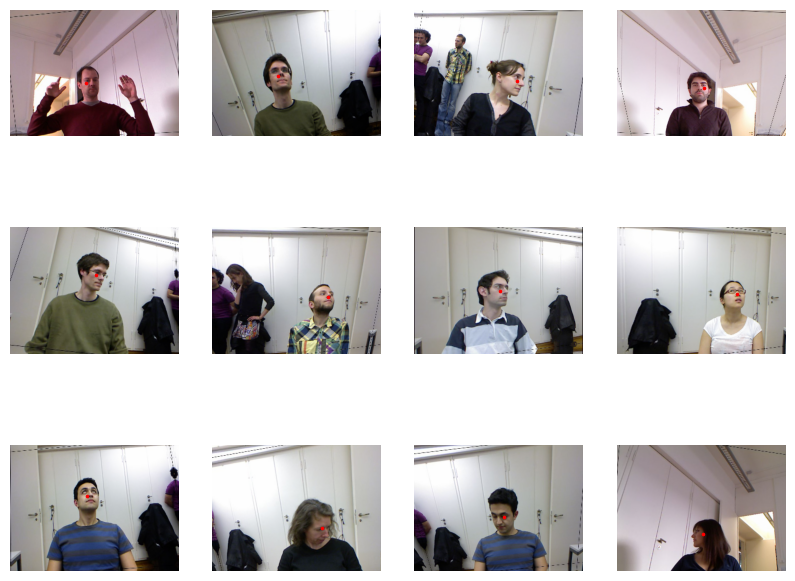

In [9]:
dls = biwi.dataloaders(path,bs = 12)
dls.show_batch(max_n=12,figsize = (10,8))

In [10]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([12, 3, 240, 320]), torch.Size([12, 1, 2]))

In [11]:
#A sample of the center point of the image
yb[0]

TensorPoint([[0.1838, 0.4861]])

In [12]:
#A sample of an image
xb[0]

TensorImage([[[ 4.7542e-02,  2.2515e-02,  6.8371e-03,  ...,  2.2614e-02,
                3.8615e-02,  2.4324e-02],
              [ 3.2136e-02,  4.8995e-02,  1.0265e-01,  ...,  1.3946e-02,
                5.3131e-02,  2.6752e-02],
              [-1.8887e-02,  9.3972e-02,  2.8507e-01,  ...,  1.3946e-02,
                1.8980e-02, -1.1122e-02],
              ...,
              [ 1.7462e-01,  1.5637e-01,  1.4619e-01,  ..., -1.2143e+00,
               -1.1759e+00, -1.1300e+00],
              [ 1.5620e-01,  1.4198e-01,  1.3768e-01,  ..., -1.8027e+00,
               -1.9327e+00, -1.9474e+00],
              [ 1.5829e-01,  1.3768e-01,  1.4291e-01,  ..., -2.0970e+00,
               -2.0267e+00, -2.0897e+00]],

             [[-2.4544e-01, -2.5054e-01, -2.4129e-01,  ..., -7.8904e-02,
               -6.2617e-02, -7.7165e-02],
              [-2.6606e-01, -2.1120e-01, -1.2850e-01,  ..., -8.7723e-02,
               -4.7837e-02, -7.4693e-02],
              [-2.9184e-01, -1.7398e-01,  2.4964e-02,  ...,

In [13]:
learn = vision_learner(dls,resnet18,y_range=(-1,1))
#y_range to tell fastai the range of our targets


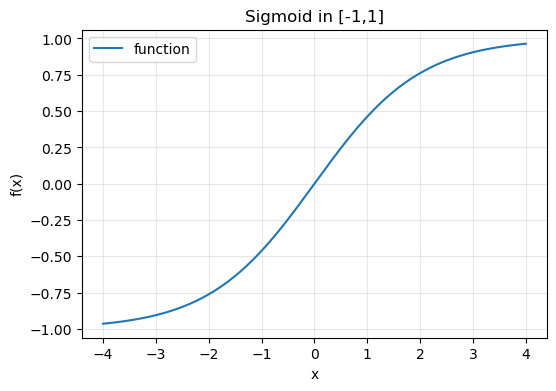

In [14]:
import torch
import matplotlib.pyplot as plt

def plot_function(f, min=-2, max=2, steps=1000, title=None):
    x = torch.linspace(min, max, steps)
    y = f(x)
    x_np, y_np = x.numpy(), y.detach().numpy()
    plt.figure(figsize=(6,4))
    plt.plot(x_np, y_np, label=f.__name__ if hasattr(f, "__name__") else "function")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi - lo) + lo

from functools import partial
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4, title="Sigmoid in [-1,1]")


In [15]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0003981071640737355)

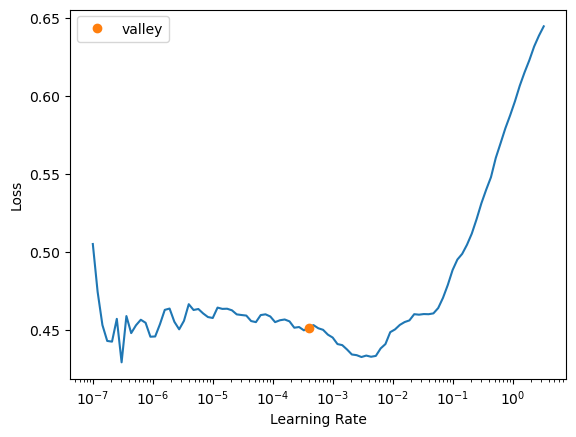

In [16]:
#we can find a good lr with learning curve finder
learn.lr_find()

an lr around  3e-3 and 2e-2 looks good
we can now train the model on these lrs now

In [17]:
lr = 3e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.027100,0.014038,11:21
1,0.010184,0.001280,12:04
2,0.004753,0.000860,11:20
3,0.004341,0.001216,11:26
4,0.004062,0.000988,12:20


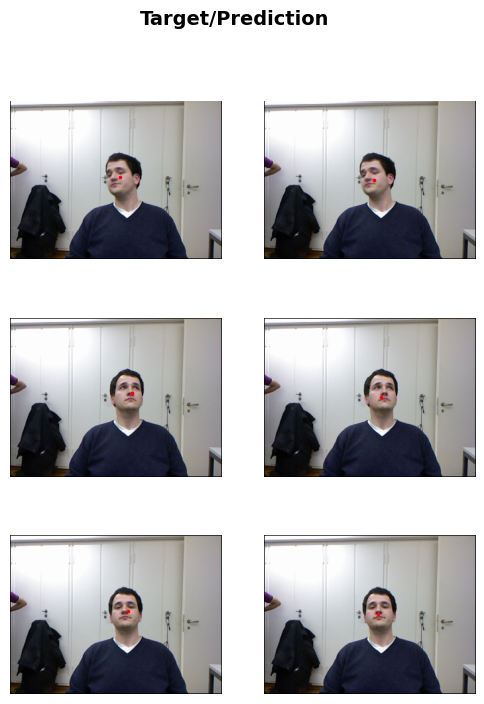

In [18]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

In [21]:
model_path = Path('./models')
learn.save(model_path/'biwi-head-pose-model')

Path('models/models/biwi-head-pose-model.pth')

In [19]:
# Get predictions for the validation set
preds, targs = learn.get_preds()

# You can manually calculate the root mean squared error
rmse = ((preds-targs)**2).mean().sqrt()
print(f"Validation RMSE: {rmse.item()}")

Validation RMSE: 0.0775461420416832


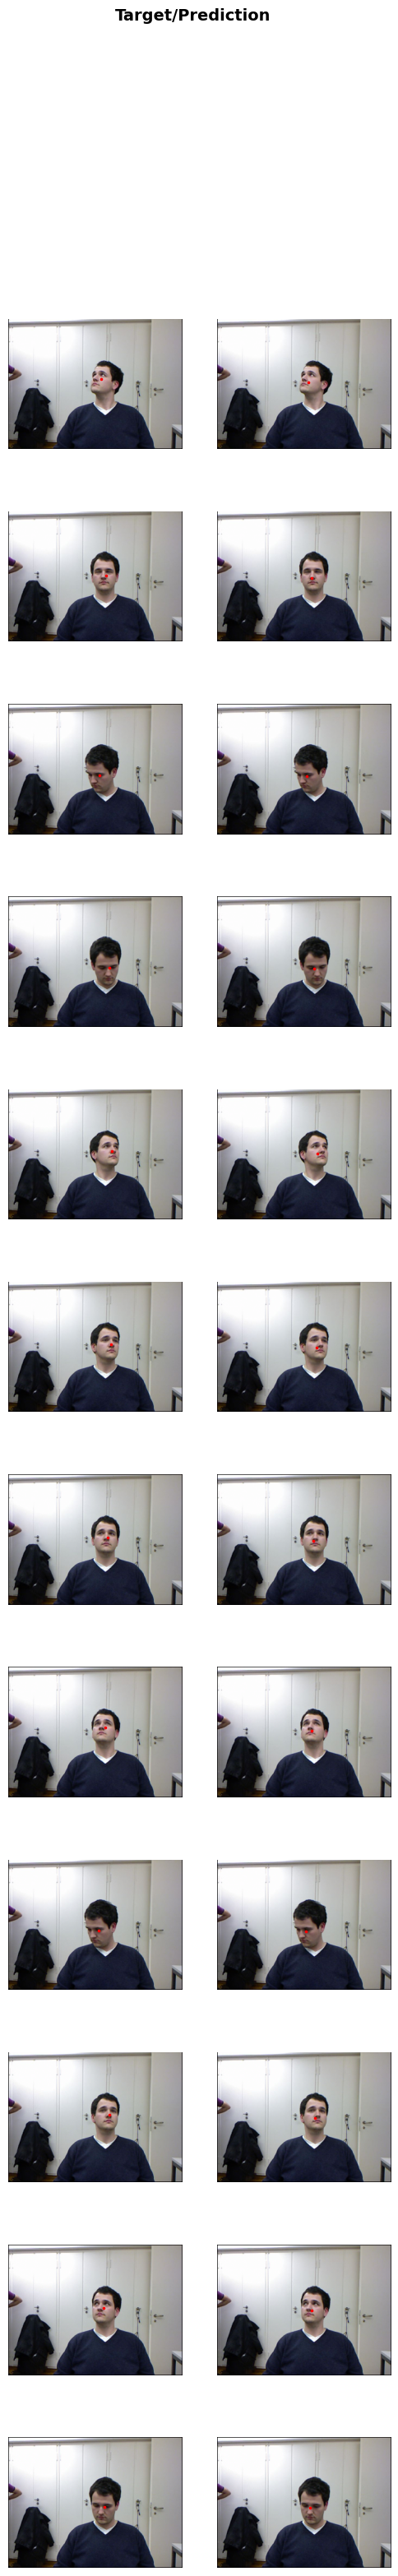

In [20]:
# Show a batch of results with the actual and predicted head points
learn.show_results(max_n=16)

In [28]:
import requests
from io import BytesIO
from PIL import Image
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Headshot_of_a_woman.jpg/800px-Headshot_of_a_woman.jpg'

try:
    # Download the image from the URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    # Save it temporarily
    img.save('temp_face.jpg')
    img_path = 'temp_face.jpg'

except Exception as e:
    print(f"Could not download image: {e}")
    img_path = None

if img_path:
    # --- Step 3: Make a prediction ---
    prediction = learn.predict(img_path)
    predicted_point = prediction[0]
    
    # Open the image and scale the predicted point
    img = Image.open(img_path)
    width, height = img.size
    
    # Scaling the normalized coordinates back to pixel values
    scaled_x = (predicted_point[0].item() + 1) * width / 2
    scaled_y = (predicted_point[1].item() + 1) * height / 2

    # --- Step 4: Plot the image and the predicted point ---
    plt.imshow(img)
    plt.scatter(scaled_x, scaled_y, color='red', s=100)
    plt.title(f"Predicted Point: ({scaled_x:.2f}, {scaled_y:.2f})")
    plt.axis('off')
    plt.show()
    
else:
    print("Failed to get an image for prediction.")

Could not download image: cannot identify image file <_io.BytesIO object at 0x7fa1682e3330>
Failed to get an image for prediction.
